# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [47]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [48]:
data = pd.read_excel('geo.xlsx')

In [49]:
data_p = data[data.comment_class==1]
data_n = data[data.comment_class==-1]
data.head()

,Unnamed: 0,x,y,comment_class
0,0,37.612416,55.777454,-1
1,1,37.612416,55.777454,-1
2,2,37.603298,55.742108,-1
3,3,37.558526,55.728758,-1
4,4,37.566431,55.731794,-1


In [50]:
data_n.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95147 entries, 0 to 108805
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     95147 non-null  int64  
 1   x              95147 non-null  float64
 2   y              95147 non-null  float64
 3   comment_class  95147 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 3.6 MB


In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams

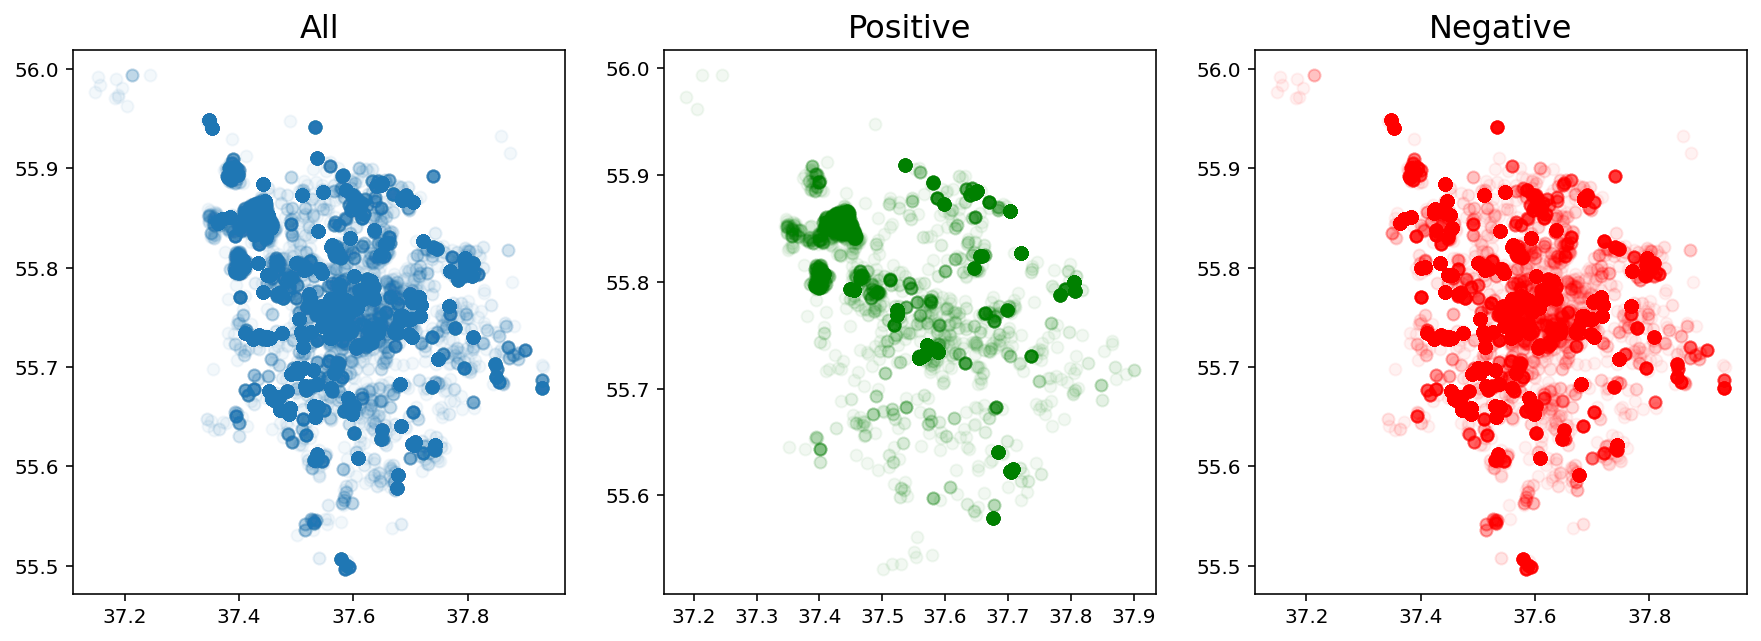

In [52]:
# отобразим плохие и хорошие голоса на карте
rcParams['figure.figsize'] = (5, 5)

# quantity rows and columns (and size)
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))           

ax1.scatter(x=data.x, y=data.y, alpha=0.05)
ax2.scatter(x=data_p.x, y=data_p.y, alpha=0.05, color='g')
ax3.scatter(x=data_n.x, y=data_n.y, alpha=0.05, color='r')

titles = ["All", "Positive", "Negative"]
colors = ["b", "g", "r"]
all_data = [data, data_p, data_n]

for number, title in zip (fig.axes, titles):
    number.set_title(title, fontsize=16)

In [53]:
from sklearn.cluster import KMeans, DBSCAN

Сначала сделаем кластеризацию с KMeans

In [54]:
data_prob = data.drop('comment_class', axis=1)
km = KMeans(n_clusters=8)
km.fit(data_prob)
clusters = km.predict(data_prob)

In [55]:
for i in range(8):
    print (i,'cluster =',len(data_prob[clusters==i]))

0 cluster = 13432
1 cluster = 13649
2 cluster = 13846
3 cluster = 13561
4 cluster = 13792
5 cluster = 13793
6 cluster = 13064
7 cluster = 13669


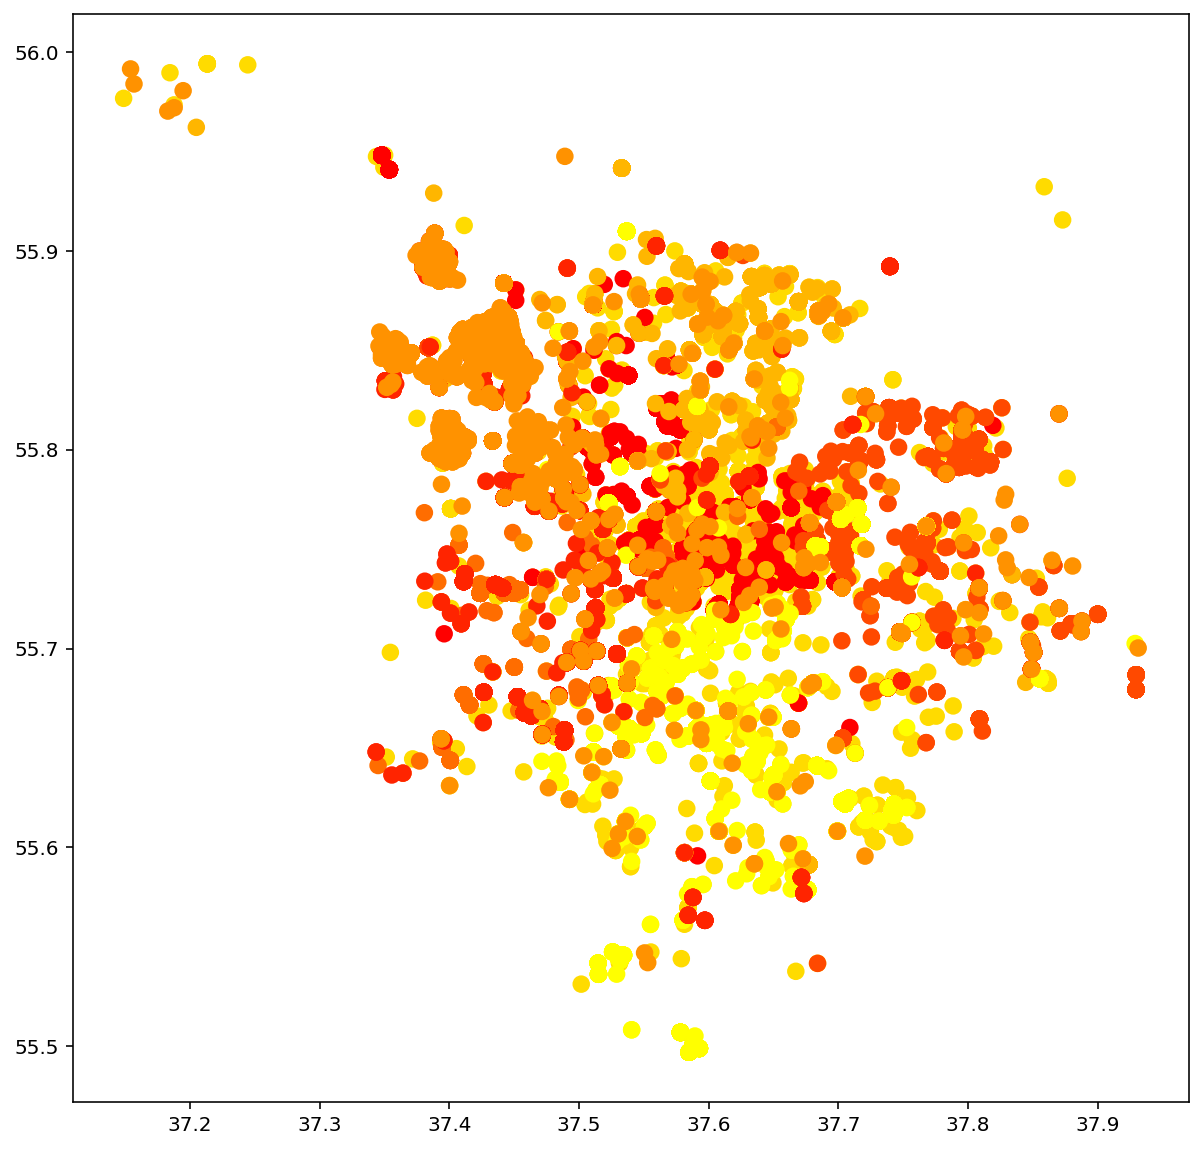

In [56]:
rcParams['figure.figsize'] = (10, 10)

#            РАБОЧИЙ, НО БОЛЕЕ ДЛИННЫЙ ВАРИАНТ
# for i,color in zip(range(8),{'blue','red','green','black','orange','yellow','brown','orchid','lime'}):
#     x_i = data_prob.x[clusters==i]
#     y_i = data_prob.y[clusters==i]
#     plt.plot(x_i, y_i, 'ro', alpha=0.1, c=color)
    

plt.scatter(data_prob.x, data_prob.y, c=clusters, cmap='autumn', s=60)

теперь определим оптимальное число кластеров

In [57]:
k_inertia = []
ks = range(1,11)

for k in ks:
    clf_km = KMeans(n_clusters=k)
    clusters_km = clf_km.fit_predict(data_prob, )
    k_inertia.append(clf_km.inertia_/100)

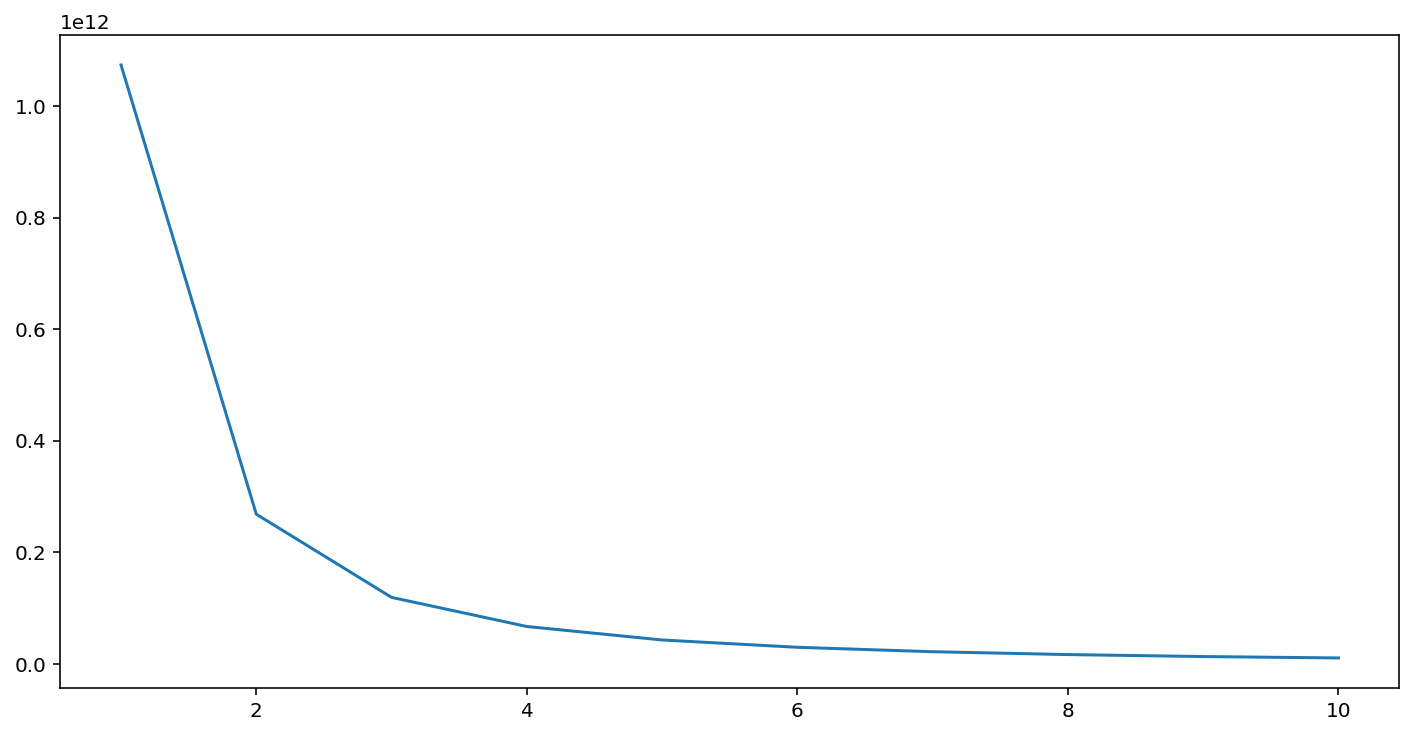

In [58]:
rcParams['figure.figsize'] = (12,6)
plt.plot(ks, k_inertia)

In [59]:
# np.diff - вычислить N-ю дискретную разность по заданной оси
diff = np.diff(k_inertia)

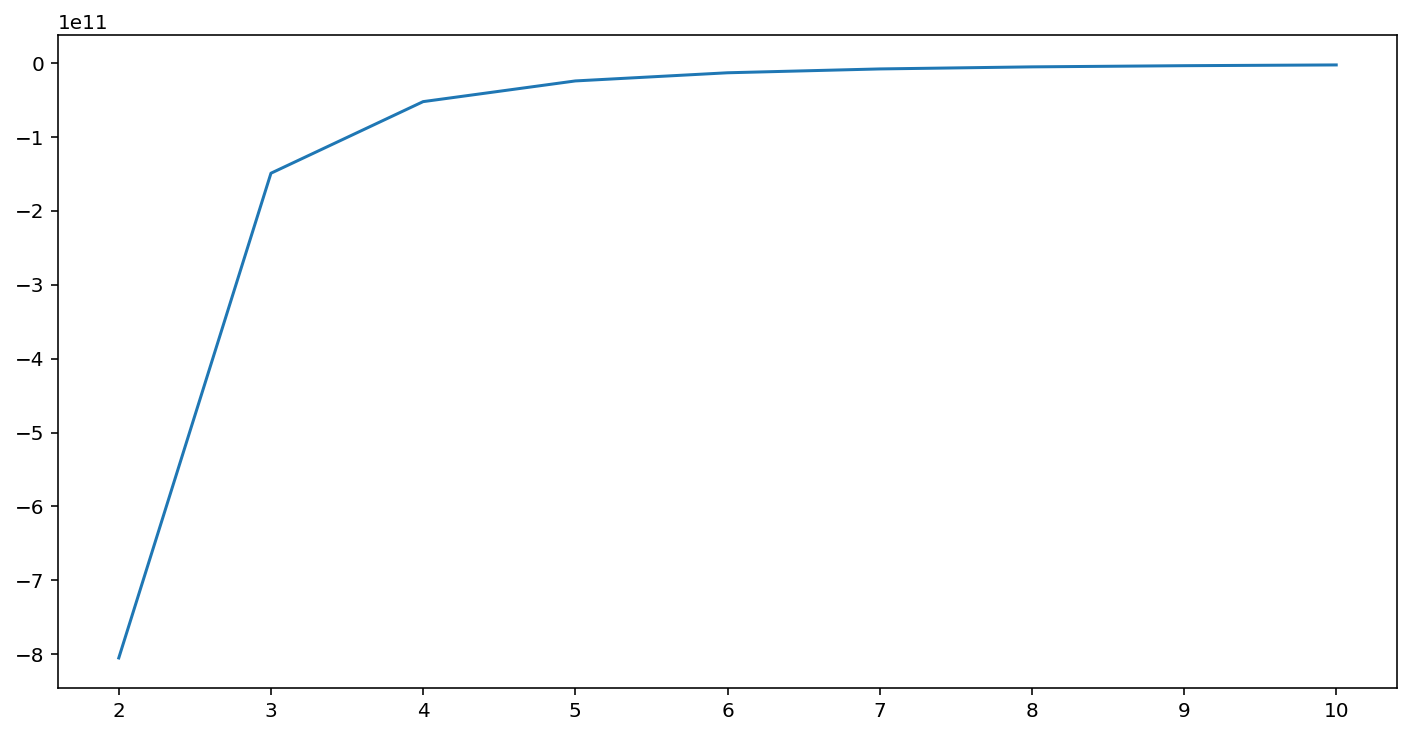

In [60]:
plt.plot(ks[1:], diff)

Исходя из графика, количество кластеров можно было бы оставить 3

Теперь найдём оптимальное число кластеров по этой формуле:

$$k_{opt} = argmin(\frac{inertia_{k+1}-inertia_{k}}{inertia_{k}-inertia_{k-1}})$$

In [61]:
diff_r = diff[1:] / diff[:-1]

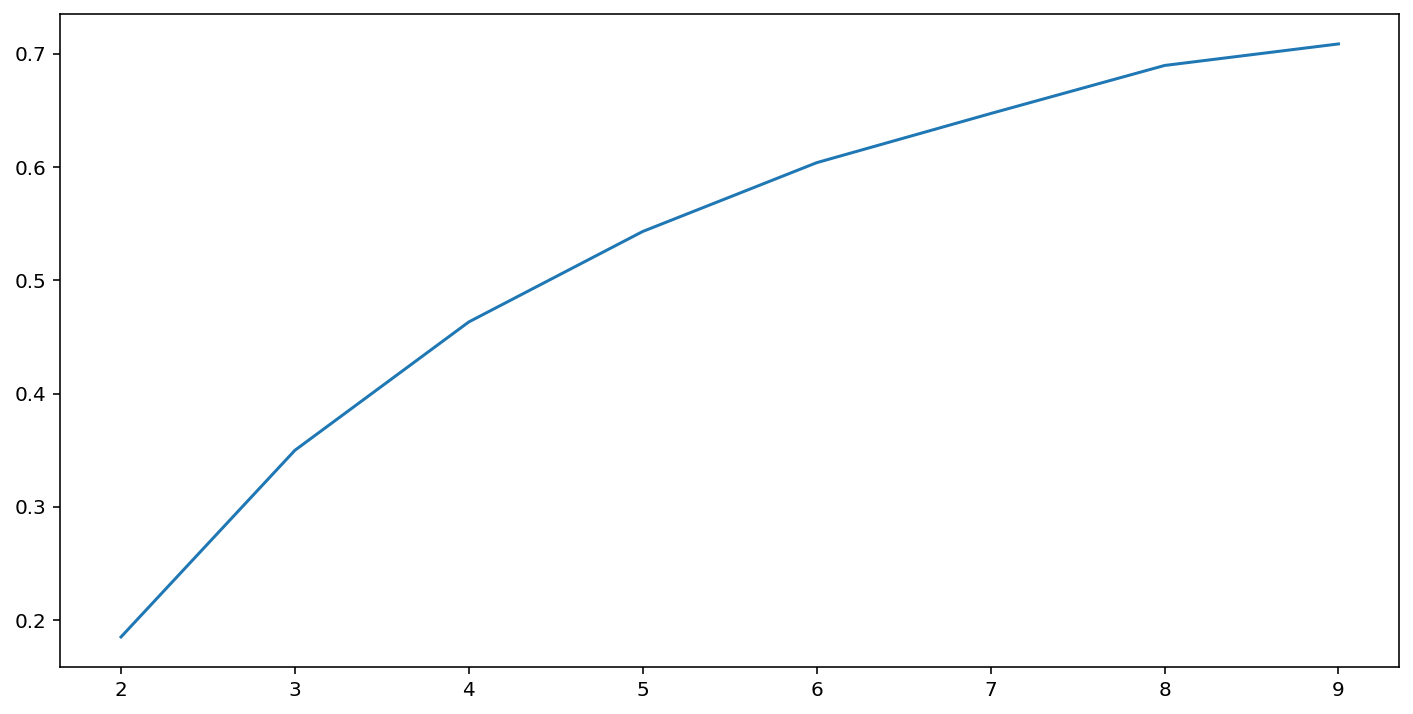

In [62]:
plt.plot(ks[1:-1], diff_r)

In [63]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

2

Это достаточно субъективная оценка, потому будем перебирать дальше

''' Закоментированно, так как слишком долго грузит. Выдает: 0.56
from sklearn.metrics import silhouette_score
silhouette_score(data_prob, clusters)'''

In [64]:
from sklearn.cluster import KMeans

In [65]:
data_p.head()

,Unnamed: 0,x,y,comment_class
28,28,37.588916,55.741982,1
45,45,37.589311,55.734273,1
46,46,37.558526,55.728758,1
47,47,37.566431,55.731794,1
61,61,37.589311,55.734273,1


In [66]:
data_p_pr = data_p.drop('comment_class', axis=1)
data_n_pr = data_n.drop('comment_class', axis=1)

In [67]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(data_p_pr)
clusters_p = kmeans.predict(data_p_pr)

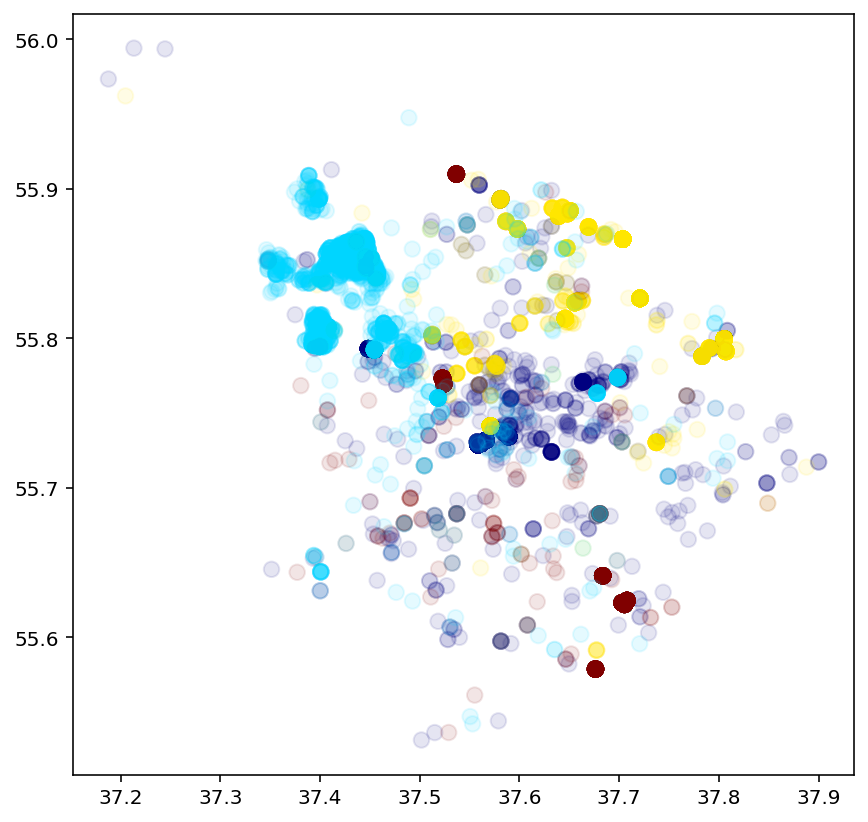

In [68]:
rcParams['figure.figsize'] = (7,7)
    
plt.scatter(data_p_pr.x, data_p_pr.y, c=clusters_p, alpha=0.1, cmap='jet', s=60)

In [69]:
kn_n = KMeans(n_clusters=8)
clusters_n = kn_n.fit_predict(data_n_pr)

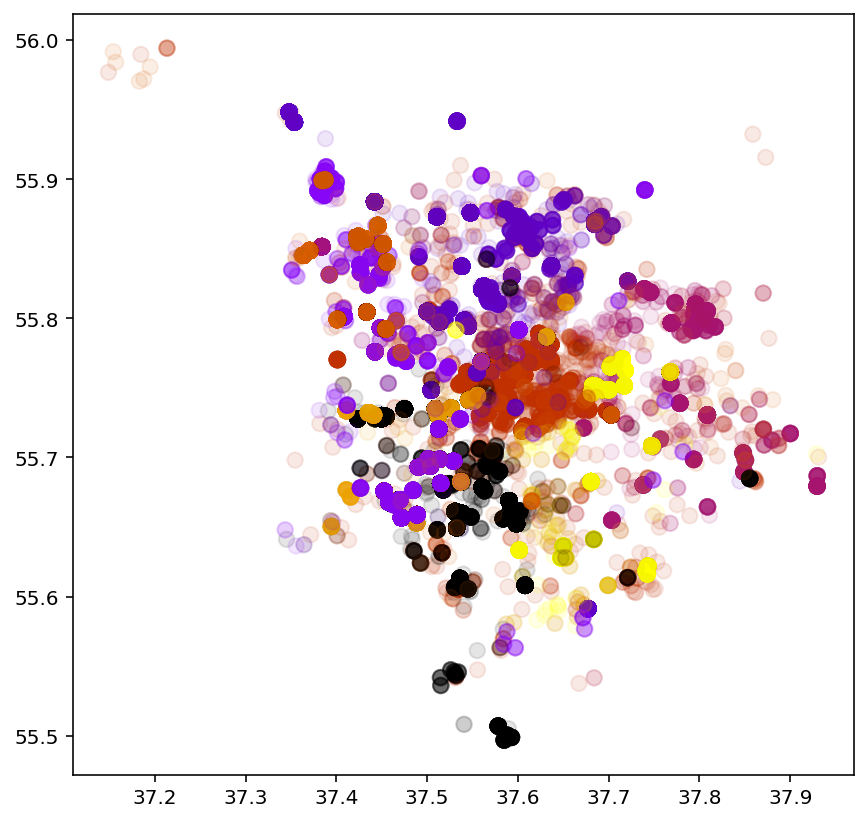

In [70]:
rcParams['figure.figsize'] = (7,7)
plt.scatter(data_n_pr.x, data_n_pr.y, c=clusters_n, alpha=0.1, cmap='gnuplot', s=60)

Теперь используем DBSCAN

In [71]:
from sklearn.cluster import KMeans, DBSCAN

In [72]:
eps_ = np.array([0.005, 0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.3, 0.5, 0.8, 1.2, 2.0, 3.0, 5.0])
min_samples_= np.array([5, 10, 50, 100, 300, 500, 1000, 2000])

In [73]:
# Так как на всей выборке считать слишком долго, возьмем лишь часть
choice = np.random.choice(data_prob.index, size=30000, replace=False).tolist()
data_x = data_prob[data_prob.index.isin(choice)]

'''# посмотрим в каких диапазонах стоит подбирать значения
for k in eps_:
    fig, axes = plt.subplots(2,5 , figsize=(15,7))
    for ax, j in zip(fig.axes ,min_s`mamples_):
        DB = DBSCAN(eps=k, min_samples=j, n_jobs=-1 )
        DB_clusters = DB.fit_predict(data_x)
        ax.scatter(data_x.x, data_x.y, c=DB_clusters, cmap='autumn', s=60)'''

Теперь найдём районы где голосовали активнее всего

DBSCAN единичный, без сетки

In [74]:
choice = np.random.choice(data_prob.index, size=50000, replace=False).tolist()
data_50 = data_prob[data_prob.index.isin(choice)]

In [75]:
#               В данном примере со стандартицацией выходит хуже
# from sklearn.preprocessing import StandardScaler
# scal = StandardScaler()
# data_50_sc = scal.fit_transform(data_50)

In [76]:
db_classic = DBSCAN(eps=0.02, min_samples=500, n_jobs=-1 )

In [77]:
db_clusters = db_classic.fit_predict(data_50)

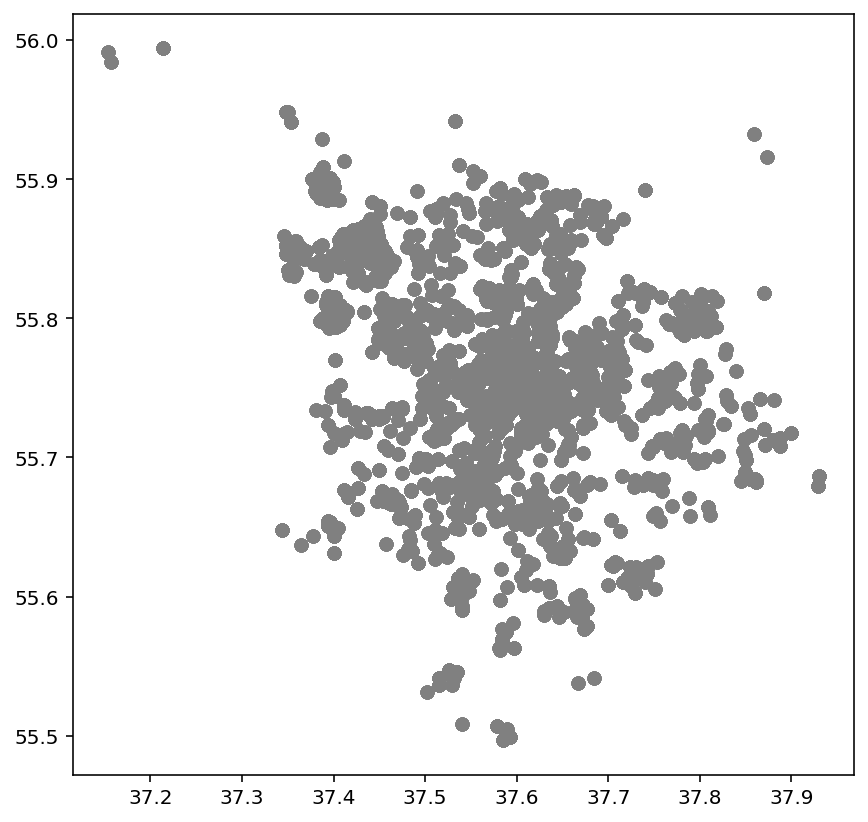

In [78]:
rcParams['figure.figsize'] = (7,7)
for i,color in zip(range(10),{'blue','red','green','black','orange','yellow','brown','orchid','lime'}):
    x_i = data_50.x[db_clusters==i]
    y_i = data_50.y[db_clusters==i]
    plt.plot(x_i, y_i, 'ro', c=color)
    plt.plot(x_i, y_i, 'ro', c=color)
    
    x_0 = data_50.x[db_clusters==-1]
    y_0 = data_50.y[db_clusters==-1]
    plt.plot(x_0, y_0, 'ro', c='grey')

Теперь выделим основные тематики коментариев жителей (негативные)

In [82]:
df = pd.read_excel('geo_comment.xlsx')

In [83]:
df_n = df[df['comment_class']==-1]
df_n = df.drop(['x', 'y', 'comment_class'], axis=1)

In [84]:
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
# from pymorphy2 import MorphAnalyzer

In [85]:
df_n.head()

,Unnamed: 0,multiplier,comment
0,0,1,Во все разделы правил землепользования и застр...
1,1,1,На основании вступившего в законную силу судеб...
2,2,1,Внести в Проект правил землепользования и заст...
3,3,1,Учитывая социальную значимость проекта строите...
4,4,1,Учитывая социальную значимость проекта строите...


Обработаем полученное описание:
   - уберем все знаки препинания
   - уберем стоп-слова
   - нормализуем и сделаем стемминг

In [86]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian")
PortSt = PorterStemmer()
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Динара\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Динара\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [87]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Динара\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [88]:
chrs_to_delete = string.punctuation + u'»' + u'«' + u'—' + u'“' + u'„' + u'•' + u'#'
translation_table = {ord(c): None for c in chrs_to_delete if c != u'-'}
# units = MorphAnalyzer.DEFAULT_UNITS
# morph = MorphAnalyzer(result_type=None, units=units)
PortSt = PorterStemmer()
stopw = set(
    [w for w in stopwords.words(['russian', 'english'])]
    + [u'это', u'году', u'года', u'также', u'етот',
       u'которые', u'который', u'которая', u'поэтому',
       u'весь', u'свой', u'мочь', u'eтот', u'например',
       u'какой-то', u'кто-то', u'самый', u'очень', u'несколько',
       u'источник', u'стать', u'время', u'пока', u'однако',
       u'около', u'немного', u'кроме', u'гораздо', u'каждый',
       u'первый', u'вполне', u'из-за', u'из-под',
       u'второй', u'нужно', u'нужный', u'просто', u'большой',
       u'хороший', u'хотеть', u'начать', u'должный', u'новый', u'день',
       u'метр', u'получить', u'далее', u'именно', u'апрель',
       u'сообщать', u'разный', u'говорить', u'делать',
       u'появиться', u'2016',
       u'2015', u'получить', u'иметь', u'составить', u'дать', u'читать',
       u'ничто', u'достаточно', u'использовать',
       u'принять', u'практически',
       u'находиться', u'месяц', u'достаточно', u'что-то', u'часто',
       u'хотеть', u'начаться', u'делать', u'событие', u'составлять',
       u'остаться', u'заявить', u'сделать', u'дело',
       u'примерно', u'попасть', u'хотя', u'лишь', u'первое',
       u'больший', u'решить', u'число', u'идти', u'давать', u'вопрос',
       u'сегодня', u'часть', u'высокий', u'главный', u'случай', u'место',
       u'конец', u'работать', u'работа', u'слово', u'важный', u'сказать']
)

In [89]:
# clean_dict = []
clean_dict = {}
counter = 0

for number, doc in zip(range(50000), df_n.comment):
    body = doc
    body = re.sub('\[.*?\]','', body)
    if body != '':
        body_clean = body.translate(translation_table).lower().strip()
        words = word_tokenize(body_clean)
        tokens = []
        # делаем стемминг и нормализацию
        for word in words:
            if re.match('^[a-z0-9-]+$', word) is not None:
                tokens.append(PortSt.stem(word))
            elif word.count('-') > 1:
                tokens.append(word)
            else:
                filtered_tokens = []
                filtered_tokens.append(word)
                for t in filtered_tokens:
                    stems = stemmer.stem(t)
                    tokens.append(stems)
        # убираем стоп-слова
        tokens = filter(
            lambda token: token not in stopw, sorted(set(tokens))
        )

        # убираем слова маленькой длины
        tokens = filter(lambda token: len(token) > 3, tokens)
    else:
        tokens = []
    counter += 1
    if counter % 500 == 0:
        print("{0} docs processed".format(counter))
    if counter == 50000: # для простоты расчета возьмем выборку из 50 000
        break
    clean_dict[number] = tokens
#     clean_dict.append(tokens)

clean_dict = {key: list(val) for key, val in clean_dict.items()}

500 docs processed
1000 docs processed
1500 docs processed
2000 docs processed
2500 docs processed
3000 docs processed
3500 docs processed
4000 docs processed
4500 docs processed
5000 docs processed
5500 docs processed
6000 docs processed
6500 docs processed
7000 docs processed
7500 docs processed
8000 docs processed
8500 docs processed
9000 docs processed
9500 docs processed
10000 docs processed
10500 docs processed
11000 docs processed
11500 docs processed
12000 docs processed
12500 docs processed
13000 docs processed
13500 docs processed
14000 docs processed
14500 docs processed
15000 docs processed
15500 docs processed
16000 docs processed
16500 docs processed
17000 docs processed
17500 docs processed
18000 docs processed
18500 docs processed
19000 docs processed
19500 docs processed
20000 docs processed
20500 docs processed
21000 docs processed
21500 docs processed
22000 docs processed
22500 docs processed
23000 docs processed
23500 docs processed
24000 docs processed
24500 docs p

In [92]:
pip install -U gensim

  Created wheel for smart-open: filename=smart_open-4.0.1-py3-none-any.whl size=108253 sha256=8fd0e6ede527174b340f6bb3f0e553b8d9757c524e13552311c7a004b5672718
  Stored in directory: c:\users\динара\appdata\local\pip\cache\wheels\8c\f9\f4\4ddd9ddee3488f48be20e9bf3108961f03ae23da29b7ed26d1
Successfully built smart-open
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
Note: you may need to restart the kernel to use updated packages.


In [93]:
from gensim.corpora import TextCorpus
from gensim.models.ldamodel import LdaModel

class ListTextCorpus(TextCorpus):

    def get_texts(self):
        for doc in self.input:
            yield doc
                
mycorp = ListTextCorpus(input=clean_dict.values())
justlda = LdaModel(
    corpus=mycorp, num_topics=4, passes=30
)

In [94]:
# Получаем описание 4 тематик
print('LdaModel performance')
for i in range(4):
    terms = justlda.get_topic_terms(i)
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))

LdaModel performance
0 земл представлен сквер транспорт земел изменен отношен округ застроен частност
1 утвержден район жител категорическ прот территор документ застройк строительств улиц
2 требу числ здан сохран озеленен участк земельн объект охра проект
3 котор адрес прав план строительств район жител москв слушан размест
